## Imports

In [317]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix

In [318]:
seed = 42
np.random.seed(seed)

## Data Preprocessing

In [319]:
class Preprocessor():
    def __init__(self, _data_path: str, _label_col: str, _correlation_threshold: float = 0):
        self.label_col = _label_col
        self.data = pd.read_csv(_data_path)
        self.correlation_threshold = _correlation_threshold
        self.x = None
        self.y = None
    
    def select_features(self):
        selected_features = []
        x_df = pd.DataFrame(self.x)
        y_series = pd.Series(self.y)
        for column in x_df.columns:
            if abs(x_df[column].corr(y_series)) > self.correlation_threshold:
                selected_features.append(column)
        self.x = self.x[selected_features]
  
    def clean_data(self):
        self.data = self.data.dropna(subset=[self.label_col])
        self.data = self.data.drop_duplicates()

    def encode_data(self):
        label_encoder = LabelEncoder()
        for column in self.x.columns:
            if self.x[column].dtype == 'object':
                self.x = pd.get_dummies(self.x, columns=[column])
    
    def scale_data(self, _mode = 'standard'):
        numerical_columns = []
        for column in self.x.columns:
            if self.x[column].dtype not in [type(object), type(bool)]:
                numerical_columns.append(column)
        if _mode == 'standard':
            scaler = StandardScaler()
        elif _mode == 'minmax':
            scaler = MinMaxScaler()
        self.x[numerical_columns] = scaler.fit_transform(self.x[numerical_columns])
    
    def preprocess_data(self):
        if self.x == None and self.y == None:
            self.clean_data()
            self.x = self.data.drop(columns=[self.label_col])
            self.y = self.data[self.label_col]
            self.y = LabelEncoder().fit_transform(self.y)
            self.encode_data()
            self.scale_data()
            self.select_features()
        return np.array(self.x), np.array(self.y)


In [320]:
class TelcoPreprocessor(Preprocessor):
    def __init__(self, _data_path: str, _label_col: str, _correlation_threshold: float = 0):
        super().__init__(_data_path, _label_col, _correlation_threshold)

    def preprocess_data(self):
        self.data = self.data.drop(columns=['customerID'])
        self.data['TotalCharges'] = pd.to_numeric(self.data['TotalCharges'], errors='coerce')
        self.data = self.data.dropna(subset=['TotalCharges'])
        return super().preprocess_data() 

In [321]:
class AdultPreprocessor(Preprocessor):
    def __init__(self, _data_path: str, _label_col: str, _correlation_threshold: float = 0):
        super().__init__(_data_path, _label_col, _correlation_threshold)

    def preprocess_data(self):
        self.data = self.data.drop(columns=['fnlwgt'])
        return super().preprocess_data()

In [322]:
class CreditPreprocessor(Preprocessor):
    def __init__(self, _data_path: str, _label_col: str, _correlation_threshold: float = 0):
        super().__init__(_data_path, _label_col, _correlation_threshold)

    def preprocess_data(self):
        # randomly selected 20000 negative samples + all positive samples
        positive_samples = self.data[self.data['Class'] == 1]
        negative_samples = self.data[self.data['Class'] == 0].sample(n=20000)
        self.data = pd.concat([positive_samples, negative_samples])
        return super().preprocess_data()

## Logistic Regression

In [323]:
class Model(ABC):
    @abstractmethod
    def __init__(self, train_x: np.ndarray, train_y: np.ndarray, config: dict):
        self.train_x = train_x
        self.train_y = train_y
        self.config = config

    @abstractmethod
    def fit(self):
        pass
    
    @abstractmethod
    def predict(self, x: np.ndarray):
        pass

    @abstractmethod
    def test(self, x: np.ndarray, y: np.ndarray):
        pass

In [324]:
class BinaryClassifier(Model):
    @abstractmethod
    def __init__(self, train_x: np.ndarray, train_y: np.ndarray, val_x: np.ndarray, val_y: np.ndarray, config: dict):
        super().__init__(train_x, train_y, config)
        self.val_x = val_x
        self.val_y = val_y

    @abstractmethod
    def h(self, x: np.ndarray):
        pass
   
    def calculate_metrics(self, _x: np.ndarray, _y: np.ndarray):
        y_true = _y 
        y_pred = self.predict(_x)
        y_pred_prob = self.h(_x)


        metrics = {}
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['sensitivity'] = recall_score(y_true, y_pred)
        metrics['f1'] = f1_score(y_true, y_pred)
        tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()
        if tn + fp == 0:
            metrics['specificity'] = 1
        else:
            metrics['specificity'] = tn / (tn + fp)
        metrics['auroc'] = roc_auc_score(y_true, y_pred_prob)
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_prob)
        metrics['aupr'] = auc(recall_curve, precision_curve)
        return metrics
 

In [325]:
class LogisticRegressor(BinaryClassifier):
    def __init__(self, train_x: np.ndarray, train_y: np.ndarray, val_x: np.ndarray = None, val_y: np.ndarray = None, config: dict = {}):
        if config == {}:
            config = {
                'lr': 0.01,
                'l1_lambda': 0.0,
                'l2_lambda': 0.0,
                'epoch': 3,
                'batch_size': 1, 
                'verbose': False
            }
        super().__init__(train_x, train_y, val_x, val_y, config)
        self.__w = np.zeros(self.train_x.shape[1])

    def __miniBGD(self, _lr: float, _epoch: int, _batch_size: int, _verbose: bool, l1_lambda: float = 0.0, l2_lambda: float = 0.0):
        _batch_size = min(_batch_size, self.train_y.size)
        for ep in range(_epoch):
            for i in range(0, self.train_y.size, _batch_size):

                gradient = self.train_x[i:i+_batch_size].T @ (self.h(self.train_x)[i:i+_batch_size] - self.train_y[i:i+_batch_size]) / _batch_size

                if l1_lambda > 0:
                    gradient += l1_lambda * np.sign(self.__w)
                if l2_lambda > 0:
                    gradient += 2 * l2_lambda * self.__w
                
                self.__w -= _lr * gradient

                if _verbose:
                    print(f'Epoch {ep+1}/{_epoch} | Batch {i//_batch_size+1}/{self.train_y.size//_batch_size} - Loss: {self.__negative_log_likelihood(self.train_x[i:i+_batch_size], self.train_y[i:i+_batch_size])}')
            
            if _verbose:
                metrics = self.calculate_metrics(self.train_x, self.train_y)
                print(f'Epoch {ep+1}/{_epoch} - Loss: {self.__negative_log_likelihood(self.train_x, self.train_y)} | Accuracy: {metrics["accuracy"]} | Sensitivity: {metrics["sensitivity"]} | Specificity: {metrics["specificity"]} | Precision: {metrics["precision"]} | F1: {metrics["f1"]} | AUROC: {metrics["auroc"]} | AUPR: {metrics["aupr"]}')
            
            if self.val_x is not None and self.val_y is not None and _verbose:
                val_metrics = self.calculate_metrics(self.val_x, self.val_y)
                print(f'Validation - Loss: {self.__negative_log_likelihood(self.val_x, self.val_y)} | Accuracy: {val_metrics["accuracy"]} | Sensitivity: {val_metrics["sensitivity"]} | Specificity: {val_metrics["specificity"]} | Precision: {val_metrics["precision"]} | F1: {val_metrics["f1"]} | AUROC: {val_metrics["auroc"]} | AUPR: {val_metrics["accuracy"]}')

   
    def __negative_log_likelihood(self, _x: np.ndarray, _y: np.ndarray):
        return -np.sum(_y * np.log(self.h(_x)) + (1 - _y) * np.log(1 - self.h(_x))) / _y.size

    def h(self, x: np.ndarray):
        assert x.shape[1] == self.__w.size
        return 1 / (1 + np.exp(-x @ self.__w))
    
    def fit(self):
        self.__miniBGD(self.config['lr'], self.config['epoch'], self.config['batch_size'], self.config['verbose'])
        return self.calculate_metrics(self.train_x, self.train_y)
    
    def predict(self, x: np.ndarray):
        p = self.h(x)
        return np.where(p > 0.5, 1, 0)
    
    def test(self, x: np.ndarray, y: np.ndarray):
        return self.calculate_metrics(x, y)


## Ensemble

In [326]:
class Bootstrapper:
    def __init__(self, train_x: np.ndarray, train_y: np.ndarray, val_x: np.ndarray = None, val_y: np.ndarray = None):
        self.train_x = train_x
        self.train_y = train_y
        self.val_x = val_x
        self.val_y = val_y
        self.estimators = []
    
    def __bootstrap_sample(self):
        indices = np.random.choice(self.train_y.size, size=self.train_y.size, replace=True)
        return self.train_x[indices], self.train_y[indices]
    
    def __fit_estimators(self, config):
        self.estimators = []
        for i in range(config['n_estimators']):
            if config['verbose'] == True:
                print(f'\nFitting estimator {i+1}/{config["n_estimators"]}')
            train_x_sample, train_y_sample = self.__bootstrap_sample()
            estimator = LogisticRegressor(train_x_sample, train_y_sample, self.val_x, self.val_y, config)
            estimator.fit()
            self.estimators.append(estimator)
    
    def get_estimators(self, config):
        self.__fit_estimators(config)
        return self.estimators
 

In [327]:
class Ensembler(BinaryClassifier):
    def __init__(self, train_x: np.ndarray, train_y: np.ndarray, val_x: np.ndarray = None, val_y: np.ndarray = None, config: dict = {}, estimators: list = []):
        if config == {}:
            config = {
                'lr': 0.01,
                'l1_lambda': 0.0,
                'l2_lambda': 0.0,
                'epoch': 3,
                'batch_size': 1, 
                'n_estimators': 9,
                'verbose': False
            }
 
        super().__init__(train_x, train_y, val_x, val_y, config)
        self._estimators = estimators
        self._bootstrapper = Bootstrapper(train_x, train_y, val_x, val_y)
    
    def __get_all_metrics(self):
        metrics = []
        for estimator in self._estimators:
            metrics.append(estimator.calculate_metrics(self.train_x, self.train_y))
        return metrics
    
    def draw_violin_plot(self, figsize: tuple = (10, 5), title: str = ''):
        assert len(self._estimators) > 0 
        metrics = self.__get_all_metrics()
        metrics = pd.DataFrame(metrics)
        metrics = metrics.melt(var_name='Metric', value_name='Value')
        palette = sns.color_palette('husl', metrics['Metric'].nunique())
        plt.figure(figsize=figsize)
        plt.title(title)
        sns.violinplot(x='Metric', y='Value', data=metrics, hue='Metric', palette=palette, legend=False)
        plt.show()

    def fit(self):
        if self._estimators == []:
            self._estimators = self._bootstrapper.get_estimators(self.config)
        return self.calculate_metrics(self.train_x, self.train_y)

    def predict(self, x: np.ndarray):
        p = self.h(x)
        return np.where(p > 0.5, 1, 0)

    def test(self, x: np.ndarray, y: np.ndarray):
        return self.calculate_metrics(x, y)

In [328]:
class MeanEnsembler(Ensembler):
    def __init__(self, train_x: np.ndarray, train_y: np.ndarray, val_x: np.ndarray = None, val_y: np.ndarray = None, config: dict = {}, estimators: list = []):
        super().__init__(train_x, train_y, val_x, val_y, config, estimators)
   
    def h(self, x: np.ndarray):
        assert self._estimators != []
        return np.mean([estimator.h(x) for estimator in self._estimators], axis=0)

In [329]:
class MultipleRegressor(Ensembler):
    def __init__(self, train_x: np.ndarray, train_y: np.ndarray, val_x: np.ndarray = None, val_y: np.ndarray = None, config: dict = {}, estimators: list = []):
        super().__init__(train_x, train_y, val_x, val_y, config, estimators)
 
    def calculate_metrics(self, _x: np.ndarray, _y: np.ndarray):
        assert self._estimators != []
        metrics = self._estimators[0].calculate_metrics(_x, _y)
        for estimator in self._estimators[1:]:
            metrics_estimator = estimator.calculate_metrics(_x, _y)
            for key in metrics.keys():
                metrics[key] += metrics_estimator[key]
        for key in metrics.keys():
            metrics[key] /= self.config['n_estimators']
            std_dev = np.std([estimator.calculate_metrics(_x, _y)[key] for estimator in self._estimators])
            metrics[key] = f'{metrics[key]:.2f}/{std_dev:.4f}'
        return metrics

    def h(self, x: np.ndarray):
        assert self._estimators != []
        return np.mean([estimator.h(x) for estimator in self._estimators], axis=0)

In [330]:
class VotingEnsembler(Ensembler):
    def __init__(self, train_x: np.ndarray, train_y: np.ndarray, val_x: np.ndarray = None, val_y: np.ndarray = None, config: dict = {}, estimators: list = []):
        super().__init__(train_x, train_y, val_x, val_y, config, estimators)
   
    def h(self, x: np.ndarray):
        assert self._estimators != []
        return np.median([estimator.h(x) for estimator in self._estimators], axis=0)
    
    def predict(self, x: np.ndarray):
        votes = np.array([estimator.predict(x) for estimator in self._estimators])
        return np.where(np.sum(votes, axis=0) > len(self._estimators) / 2, 1, 0)
    

In [331]:
class StackingEnsembler(Ensembler):
    def __init__(self, train_x: np.ndarray, train_y: np.ndarray, val_x: np.ndarray = None, val_y: np.ndarray = None, config: dict = {}, estimators: list = []):
        super().__init__(train_x, train_y, val_x, val_y, config, estimators)
        self.__meta_x = None
        self.__meta_y = None
        self.__meta_learner = None
    
    def __generate_meta_x(self, x: np.ndarray):
        assert self._estimators != []
        meta_x = np.array([estimator.h(x) for estimator in self._estimators]).T
        meta_x = np.concatenate((x, meta_x), axis=1)
        return meta_x
    
    def __generate_metaset(self):
        if self.val_x is None or self.val_y is None:
            self.val_x = self.train_x
            self.val_y = self.train_y
        self.__meta_x = self.__generate_meta_x(self.val_x)
        self.__meta_y = self.val_y
    
    def __fit_meta_learner(self, _lr: float, _epoch: int, _batch_size: int, _verbose: bool):
        if self.__meta_x == None or self.__meta_y == None:
            self.__generate_metaset()
        self.__meta_learner = LogisticRegressor(self.__meta_x, self.__meta_y, config=self.config)
        if _verbose:
            print('\nFitting meta learner')
        self.__meta_learner.fit()
    
    def h(self, x: np.ndarray):
        assert self.__meta_learner != None
        meta_x = self.__generate_meta_x(x)
        return self.__meta_learner.h(meta_x)
    
    def fit(self):
        if self._estimators == []:
            self._estimators = self._bootstrapper.get_estimators(self.config)
        self.__fit_meta_learner(self.config['lr'], self.config['epoch'], self.config['batch_size'], self.config['verbose'])
        return self.calculate_metrics(self.train_x, self.train_y)
    
    def predict(self, x: np.ndarray):
        meta_x = self.__generate_meta_x(x)
        return self.__meta_learner.predict(meta_x)

In [332]:
def benchmark(preprocessor, config):
    x, y = preprocessor.preprocess_data()
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=seed)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=seed)

    print(f'\nTotal Features: {x.shape[1]}')
    print(f'\nTotal samples: {x.shape[0]} | Train samples: {train_x.shape[0]} | Validation samples: {val_x.shape[0]} | Test samples: {test_x.shape[0]}')
    print(f'\nConfiguration: {config}')

    models = {}
    models['logistic_regressor'] = LogisticRegressor(train_x, train_y, val_x, val_y, config)

    bootstrapper = Bootstrapper(train_x, train_y, val_x, val_y)
    estimators = bootstrapper.get_estimators(config)
    models['mean_ensembler'] = MeanEnsembler(train_x, train_y, val_x, val_y, config, estimators)
    models['multiple_regressor'] = MultipleRegressor(train_x, train_y, val_x, val_y, config, estimators)
    models['voting_ensembler'] = VotingEnsembler(train_x, train_y, val_x, val_y, config, estimators)
    models['stacking_ensembler'] = StackingEnsembler(train_x, train_y, val_x, val_y, config, estimators)

    metrics = []
    for model_name, model in models.items():
        model.fit()
        metrics.append([model_name] + list(model.test(test_x, test_y).values()))

    metrics = pd.DataFrame(metrics, columns=['Model', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1', 'AUROC', 'AUPR'])
    return metrics, models
    


Total Features: 45

Total samples: 7010 | Train samples: 4486 | Validation samples: 1122 | Test samples: 1402

Configuration: {'lr': 0.1, 'l1_lambda': 0.0, 'l2_lambda': 0.01, 'epoch': 1000, 'batch_size': 1000000, 'n_estimators': 9, 'verbose': False}


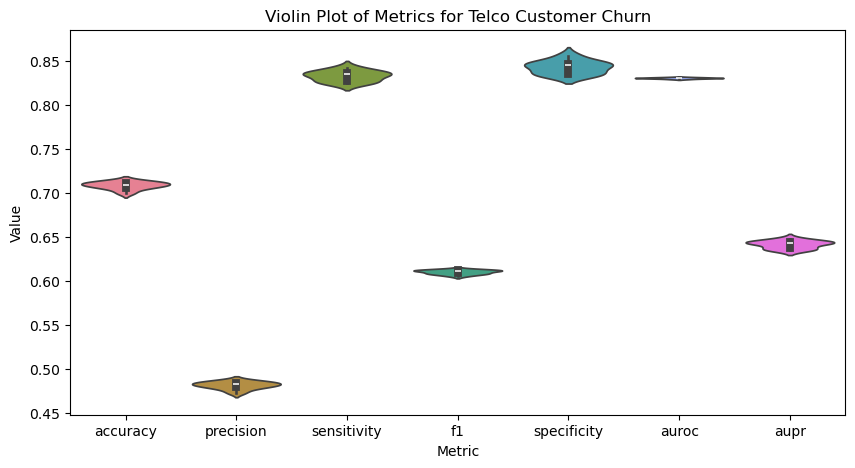

,Model,Accuracy,Sensitivity,Specificity,Precision,F1,AUROC,AUPR
0,logistic_regressor,0.701854,0.424337,0.847352,0.565489,0.882775,0.84513,0.62848
1,mean_ensembler,0.704708,0.427002,0.847352,0.56785,0.881643,0.845911,0.632563
2,multiple_regressor,0.70/0.0069,0.42/0.0061,0.85/0.0085,0.56/0.0051,0.88/0.0080,0.84/0.0021,0.63/0.0121
3,voting_ensembler,0.701141,0.423676,0.847352,0.564901,0.883055,0.84528,0.631623
4,stacking_ensembler,0.804565,0.577558,0.545171,0.560897,0.467153,0.841926,0.619301


In [333]:
telco_config = {
    'lr': 0.1,
    'l1_lambda': 0.0,
    'l2_lambda': 0.01,
    'epoch': 1000,
    'batch_size': 1000000, 
    'n_estimators': 9,
    'verbose': False 
}
telco_preprocessor = TelcoPreprocessor('./Telco-Customer-Churn.csv', 'Churn', _correlation_threshold=0)
telco_metrics, telco_models = benchmark(telco_preprocessor, telco_config)
telco_models['multiple_regressor'].draw_violin_plot(title = 'Violin Plot of Metrics for Telco Customer Churn')
telco_metrics 


Total Features: 54

Total samples: 29096 | Train samples: 18620 | Validation samples: 4656 | Test samples: 5820

Configuration: {'lr': 0.1, 'l1_lambda': 0.0, 'l2_lambda': 0.01, 'epoch': 1000, 'batch_size': 1000000, 'n_estimators': 9, 'verbose': False}


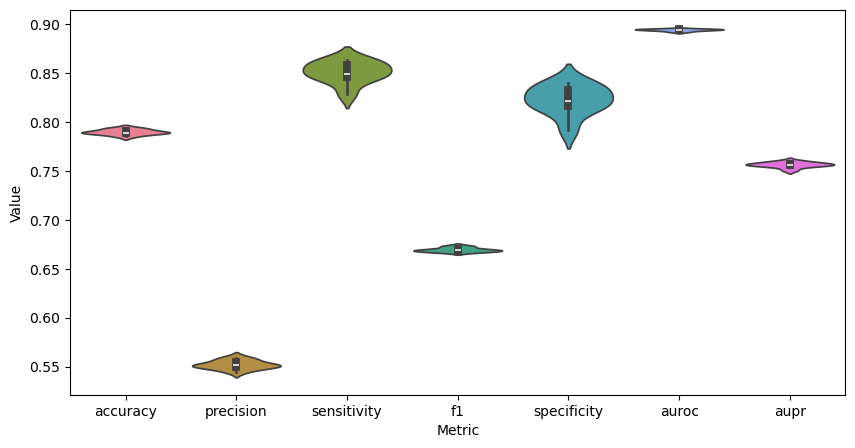

,Model,Accuracy,Sensitivity,Specificity,Precision,F1,AUROC,AUPR
0,logistic_regressor,0.787113,0.533728,0.844268,0.654007,0.825666,0.889534,0.737922
1,mean_ensembler,0.789347,0.537011,0.842105,0.655811,0.82137,0.889388,0.737646
2,multiple_regressor,0.79/0.0040,0.53/0.0062,0.84/0.0094,0.65/0.0024,0.82/0.0137,0.89/0.0011,0.74/0.0022
3,voting_ensembler,0.787801,0.534862,0.840663,0.653771,0.821053,0.889418,0.737917
4,stacking_ensembler,0.836082,0.684885,0.578226,0.627052,0.386792,0.889352,0.725573


In [334]:
adult_config = {
    'lr': 0.1,
    'l1_lambda': 0.0,
    'l2_lambda': 0.01,
    'epoch': 1000,
    'batch_size': 1000000, 
    'n_estimators': 9,
    'verbose': False
}
adult_preprocessor = AdultPreprocessor('./Adult-Census-Income.csv', 'income', _correlation_threshold=0.01)
adult_metrics, adult_models = benchmark(adult_preprocessor, adult_config)
adult_models['multiple_regressor'].draw_violin_plot()
adult_metrics


Total Features: 30

Total samples: 20468 | Train samples: 13099 | Validation samples: 3275 | Test samples: 4094

Configuration: {'lr': 0.0001, 'l1_lambda': 0.0, 'l2_lambda': 0.002, 'epoch': 1000, 'batch_size': 1000000, 'n_estimators': 9, 'verbose': False}


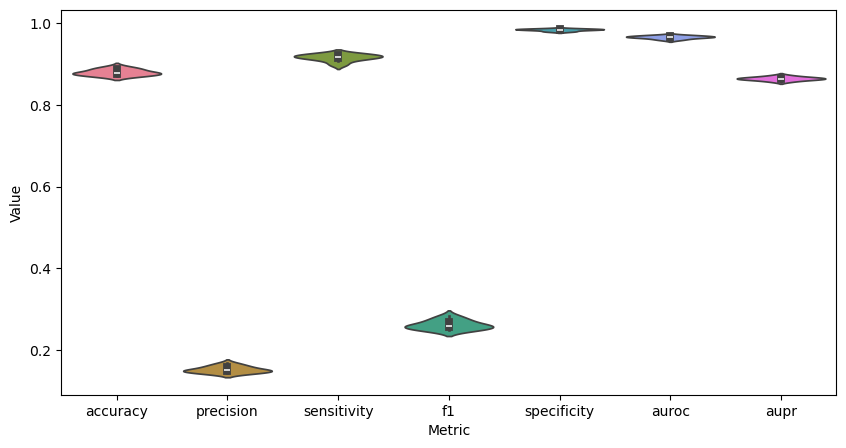

,Model,Accuracy,Sensitivity,Specificity,Precision,F1,AUROC,AUPR
0,logistic_regressor,0.875183,0.139693,0.931818,0.242963,0.988258,0.969273,0.92241
1,mean_ensembler,0.877382,0.141869,0.931818,0.246246,0.988048,0.970309,0.922038
2,multiple_regressor,0.87/0.0072,0.14/0.0066,0.93/0.0036,0.24/0.0099,0.99/0.0011,0.97/0.0020,0.92/0.0018
3,voting_ensembler,0.87958,0.144112,0.931818,0.249619,0.98783,0.970365,0.922491
4,stacking_ensembler,0.996825,0.987013,0.863636,0.921212,0.076923,0.965203,0.92342


In [335]:
credit_config = {
    'lr': 0.0001,
    'l1_lambda': 0.0,
    'l2_lambda': 0.002,
    'epoch': 1000,
    'batch_size': 1000000, 
    'n_estimators': 9,
    'verbose': False
}
credit_preprocessor = CreditPreprocessor('./Credit-Card-Fraud-Detection.csv', 'Class', _correlation_threshold=0)
credit_metrics, credit_models = benchmark(credit_preprocessor, credit_config)
credit_models['multiple_regressor'].draw_violin_plot()
credit_metrics